In [25]:
from torch import nn
import torch
from kornia.color import lab_to_rgb, rgb_to_lab, hsv_to_rgb, rgb_to_hsv
from einops import repeat
from matplotlib import pyplot as plt
import cv2
import numpy as np

class Lab_keep_white_v2(nn.Module):
    def __init__(
        self,
#         model=None,
#         device=None,
        epsilon=1e-7,
        requires_grad=True,
        
#         mu0 = None,
#         sigma0 = None,
        
        mu0 = [64, 20, -10],
        sigma0 = [12, 7, 5],
        
    ):
        super(Lab_keep_white_v2, self).__init__()
        self.epsilon = epsilon
        self.mu0 = torch.tensor(mu0)#.to(device)
        self.sigma0 = torch.tensor(sigma0)#.to(device)
        #self.device = device

        self.mu = nn.Parameter(
            torch.tensor(
                [0.0, 0.0, 0.0], dtype=torch.float32, requires_grad=requires_grad
            )
        )
        self.sigma = nn.Parameter(
            torch.tensor(
                [0.0, 0.0, 0.0], dtype=torch.float32, requires_grad=requires_grad
            )
        )
#         self.model = model if model is not None else nn.Identity()
        

    def forward(self, x):
        assert (
            x.max() <= 1 and x.min() >= 0
        ), f"image should be scaled to [0,1] rather than [0,256], current scale {x.min()}-{x.max()}"

        x = rgb_to_lab(x)

        B, _, H, W = x.shape

        mu = x.mean(axis=(2, 3))
        sigma = x.std(axis=(2, 3))
        

        mu = repeat(mu, "b c -> b c h w", h=H, w=W)
        sigma = repeat(sigma + self.epsilon, "b c -> b c h w", h=H, w=W)
        
        mu_prime = repeat(self.mu + self.mu0, "c -> b c h w", b=B, h=H, w=W)
        sigma_prime = repeat(self.sigma + self.sigma0, "c -> b c h w", b=B, h=H, w=W)
        
        x_norm = (x - mu) / sigma * sigma_prime + mu_prime
        threshold =(75 - mu[:,0,:,:]) / sigma[:,0,:,:] * sigma_prime[:,0,:,:] + mu_prime[:,0,:,:]#82
        x_norm_L = x_norm[:,0,:,:].clone()
        maximal = 100
#         print(maximal)
        n = 6
        a = 1 / ((threshold - maximal)**(n-1) - self.epsilon)
        x_norm_white = a * (x_norm[:,0,:,:] - maximal)**n + maximal
        
        x_norm[:,0,:,:] = torch.where(x_norm[:,0,:,:].long() > threshold, x_norm_white, x_norm[:,0,:,:])
        x_norm[:,0,:,:] = torch.where(x_norm_L.long() > 100, x_norm_L, x_norm[:,0,:,:])#染色归一化颜色风格有显著差距的patch时存在白色过色问题解决

        x_norm = lab_to_rgb(x_norm)
        
        return x_norm

tensor([[[53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124],
         [53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124],
         [53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124],
         ...,
         [53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124],
         [53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124],
         [53.3124, 53.3124, 53.3124,  ..., 53.3124, 53.3124, 53.3124]]],
       dtype=torch.float64)
tensor([[[74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549],
         [74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549],
         [74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549],
         ...,
         [74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549],
         [74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549],
         [74.8549, 74.8549, 74.8549,  ..., 74.8549, 74.8549, 74.8549]]],
       dtype=torch.float64)


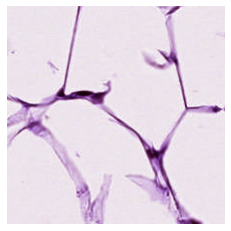

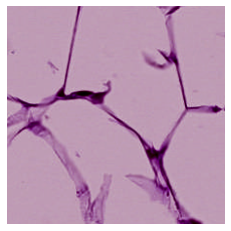

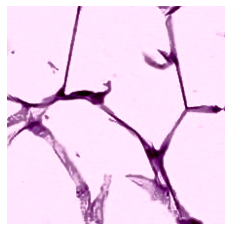

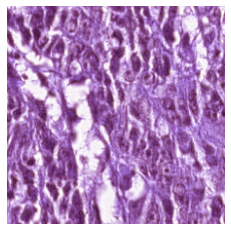

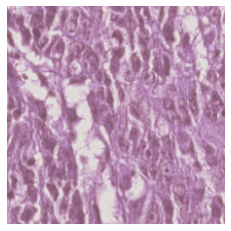

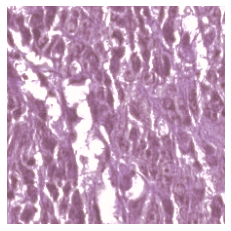

In [66]:
ADI0 = cv2.imread('/root/autodl-tmp/MIApictures/ADI-TCGA-AVCDAFNM.png')/255
TUM0 = cv2.imread('/root/autodl-tmp/MIApictures/TUM-TCGA-ARTHKYNY.png')/255
# print(ADI)
ADI = torch.tensor(ADI0).permute(2,0,1).unsqueeze(0)
# print(ADI)
TUM = torch.tensor(TUM0).permute(2,0,1).unsqueeze(0)
def transform(x):
    x = rgb_to_lab(x)

    B, _, H, W = x.shape

    mu = x.mean(axis=(2, 3))
    sigma = x.std(axis=(2, 3))


    mu = repeat(mu, "b c -> b c h w", h=H, w=W)
    sigma = repeat(sigma + 1e-7, "b c -> b c h w", h=H, w=W)

    mu_prime = repeat(torch.tensor([64, 20, -10]), "c -> b c h w", b=B, h=H, w=W)
    sigma_prime = repeat(torch.tensor([12, 7, 5]), "c -> b c h w", b=B, h=H, w=W)

    x_norm = (x - mu) / sigma * sigma_prime + mu_prime
    x_norm = lab_to_rgb(x_norm)

    return x_norm

def transform_keep_white(x):
    x = rgb_to_lab(x)

    B, _, H, W = x.shape

    mu = x.mean(axis=(2, 3))
    sigma = x.std(axis=(2, 3))


    mu = repeat(mu, "b c -> b c h w", h=H, w=W)
    sigma = repeat(sigma + 1e-7, "b c -> b c h w", h=H, w=W)

    mu_prime = repeat(torch.tensor([64, 20, -10]), "c -> b c h w", b=B, h=H, w=W)
    sigma_prime = repeat(torch.tensor([12, 7, 5]), "c -> b c h w", b=B, h=H, w=W)

    x_norm = (x - mu) / sigma * sigma_prime + mu_prime
    threshold =(75 - mu[:,0,:,:]) / sigma[:,0,:,:] * sigma_prime[:,0,:,:] + mu_prime[:,0,:,:]#82
    x_norm_L = x_norm[:,0,:,:].clone()
    maximal = 100
#         print(maximal)
    n = 6
    a = 1 / ((threshold - maximal)**(n-1) - 1e-7)
    print(threshold)
    x_norm_white = a * (x_norm[:,0,:,:] - maximal)**n + maximal

    x_norm[:,0,:,:] = torch.where(x_norm[:,0,:,:].long() > threshold, x_norm_white, x_norm[:,0,:,:])
    x_norm[:,0,:,:] = torch.where(x_norm_L.long() > 100, x_norm_L, x_norm[:,0,:,:])#染色归一化颜色风格有显著差距的patch时存在白色过色问题解决

    x_norm = lab_to_rgb(x_norm)

    return x_norm

keep_white_ADI = transform_keep_white(ADI)[0].permute(1,2,0).numpy()
temnorm_ADI = transform(ADI)[0].permute(1,2,0).numpy()

keep_white_TUM = transform_keep_white(TUM)[0].permute(1,2,0).numpy()
temnorm_TUM = transform(TUM)[0].permute(1,2,0).numpy()

plt.imshow(ADI0)
# plt.savefig("ADI0.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(temnorm_ADI)
plt.savefig("temnorm_ADI.png")

plt.show()

plt.imshow(keep_white_ADI)
plt.savefig("keep_white_ADI.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(TUM0)
# plt.savefig("ADI0.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(temnorm_TUM)
plt.savefig("temnorm_TUM.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(keep_white_TUM)
plt.savefig("keep_white_TUM.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()



tensor([[[7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145],
         [7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145],
         [7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145],
         ...,
         [7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145],
         [7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145],
         [7.6145, 7.6145, 7.6145,  ..., 7.6145, 7.6145, 7.6145]]],
       dtype=torch.float64)
tensor([[[45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400],
         [45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400],
         [45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400],
         ...,
         [45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400],
         [45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400],
         [45.4400, 45.4400, 45.4400,  ..., 45.4400, 45.4400, 45.4400]]],
       dtype=torch.float64)


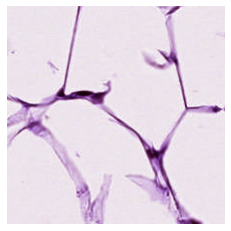

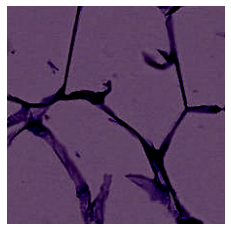

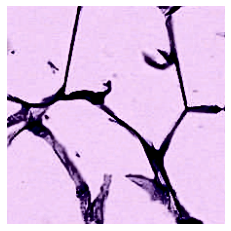

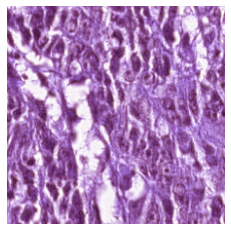

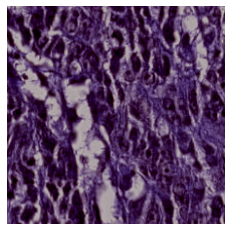

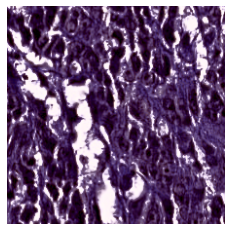

In [65]:
ADI0 = cv2.imread('/root/autodl-tmp/MIApictures/ADI-TCGA-AVCDAFNM.png')/255
TUM0 = cv2.imread('/root/autodl-tmp/MIApictures/TUM-TCGA-ARTHKYNY.png')/255
# print(ADI)
ADI = torch.tensor(ADI0).permute(2,0,1).unsqueeze(0)
# print(ADI)
TUM = torch.tensor(TUM0).permute(2,0,1).unsqueeze(0)
def transform(x):
    x = rgb_to_lab(x)

    B, _, H, W = x.shape

    mu = x.mean(axis=(2, 3))
    sigma = x.std(axis=(2, 3))


    mu = repeat(mu, "b c -> b c h w", h=H, w=W)
    sigma = repeat(sigma + 1e-7, "b c -> b c h w", h=H, w=W)

    mu_prime = repeat(torch.tensor([26.38038809,21.939772,-18.54567921]), "c -> b c h w", b=B, h=H, w=W)
    sigma_prime = repeat(torch.tensor([21.07028115,6.905576127,8.149537741]), "c -> b c h w", b=B, h=H, w=W)

    x_norm = (x - mu) / sigma * sigma_prime + mu_prime
    x_norm = lab_to_rgb(x_norm)

    return x_norm

def transform_keep_white(x):
    x = rgb_to_lab(x)

    B, _, H, W = x.shape

    mu = x.mean(axis=(2, 3))
    sigma = x.std(axis=(2, 3))


    mu = repeat(mu, "b c -> b c h w", h=H, w=W)
    sigma = repeat(sigma + 1e-7, "b c -> b c h w", h=H, w=W)

    mu_prime = repeat(torch.tensor([26.38038809,21.939772,-18.54567921]), "c -> b c h w", b=B, h=H, w=W)
    sigma_prime = repeat(torch.tensor([21.07028115,6.905576127,8.149537741]), "c -> b c h w", b=B, h=H, w=W)

    x_norm = (x - mu) / sigma * sigma_prime + mu_prime
    threshold =(75 - mu[:,0,:,:]) / sigma[:,0,:,:] * sigma_prime[:,0,:,:] + mu_prime[:,0,:,:]#82
    x_norm_L = x_norm[:,0,:,:].clone()
    maximal = 100
#         print(maximal)
    n = 6
    a = 1 / ((threshold - maximal)**(n-1) - 1e-7)
    print(threshold)
    x_norm_white = a * (x_norm[:,0,:,:] - maximal)**n + maximal

    x_norm[:,0,:,:] = torch.where(x_norm[:,0,:,:].long() > threshold, x_norm_white, x_norm[:,0,:,:])
    x_norm[:,0,:,:] = torch.where(x_norm_L.long() > 100, x_norm_L, x_norm[:,0,:,:])#染色归一化颜色风格有显著差距的patch时存在白色过色问题解决

    x_norm = lab_to_rgb(x_norm)

    return x_norm

keep_white_ADI = transform_keep_white(ADI)[0].permute(1,2,0).numpy()
temnorm_ADI = transform(ADI)[0].permute(1,2,0).numpy()

keep_white_TUM = transform_keep_white(TUM)[0].permute(1,2,0).numpy()
temnorm_TUM = transform(TUM)[0].permute(1,2,0).numpy()

plt.imshow(ADI0)
# plt.savefig("ADI0.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(temnorm_ADI)
plt.savefig("temnorm_ADI.png")

plt.show()

plt.imshow(keep_white_ADI)
plt.savefig("keep_white_ADI.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(TUM0)
plt.savefig("TUM0.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(temnorm_TUM)
plt.savefig("temnorm_TUM.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(keep_white_TUM)
plt.savefig("keep_white_TUM.png")
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()



No handles with labels found to put in legend.


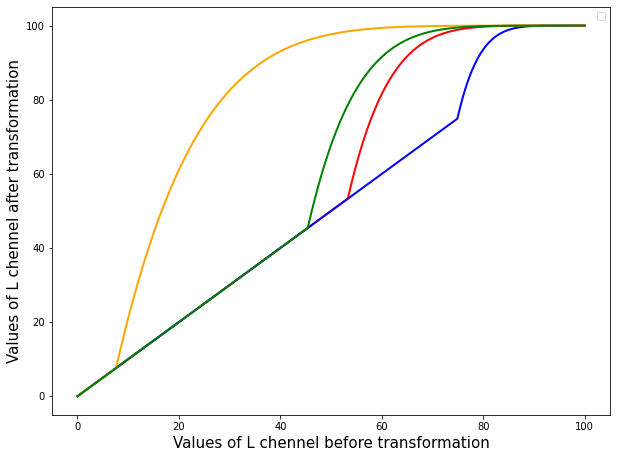

In [64]:
# 变换曲线
import time
import numpy as np
import matplotlib.pyplot as plt
n = 6
threshold1 = 53.3
threshold2 = 74.9
threshold3 = 7.61
threshold4 = 45.4

x = np.linspace(0, 100, 10000)
y1 = np.zeros(10000)
y2 = np.zeros(10000)
y3 = np.zeros(10000)
y4 = np.zeros(10000)

for i in range(10000):
    if x[i]>threshold1:
        a = 1 / ((threshold1 - 100)**(n-1) - 1e-7)
        y1[i] = a * (x[i] - 100)**n + 100
    else:
        y1[i] = x[i]
#         print(y[i])
# print(y)
for i in range(10000):
    if x[i]>threshold2:
        a = 1 / ((threshold2 - 100)**(n-1) - 1e-7)
        y2[i] = a * (x[i] - 100)**n + 100
    else:
        y2[i] = x[i]
        
for i in range(10000):
    if x[i]>threshold3:
        a = 1 / ((threshold3 - 100)**(n-1) - 1e-7)
        y3[i] = a * (x[i] - 100)**n + 100
    else:
        y3[i] = x[i]
        
for i in range(10000):
    if x[i]>threshold4:
        a = 1 / ((threshold4 - 100)**(n-1) - 1e-7)
        y4[i] = a * (x[i] - 100)**n + 100
    else:
        y4[i] = x[i]

fig, ax = plt.subplots(figsize=(10,7.5)) # 创建图实例
ax.plot(x, y1, color="red",linewidth=2)#label='linear') 
ax.plot(x, y2, color="blue",linewidth=2)
ax.plot(x, y3, color="orange",linewidth=2 )
ax.plot(x, y4, color="green",linewidth=2)

ax.set_xlabel("Values of L chennel before transformation",fontsize = 15) #设置x轴名称 x label
ax.set_ylabel("Values of L chennel after transformation",fontsize = 15) #设置y轴名称 y label
# ax.set_title('Simple Plot') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.savefig('keep_white_transform.png')
plt.show() #图形可视化

# plt.close()
